In [1]:
MAKE_BOOK_FIGURES=False
import numpy as np
import scipy.stats as st

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Gaussian Process Regression with Noise

We perform Gaussian process regression with measurement noise. The noise is assumed to be Gaussian with a known variance. The hyper-parameters of the Gaussian process are assumed to be known. See Chapter 3 of {cite:p}`10.7551/mitpress/3206.001.0001` for details.

## Example: Gaussian process regression in 1D with fixed hyper-parameters and noise

Let's generate some synthetic 1D data to work with:

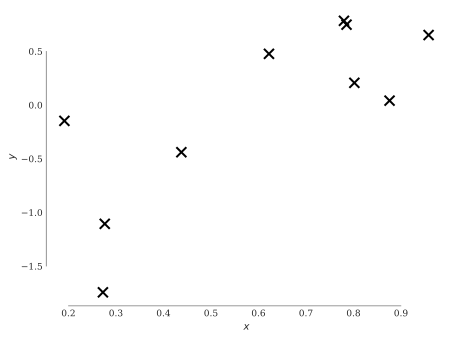

In [2]:
np.random.seed(1234)

n = 10
X = np.random.rand(n)
sigma = 0.4
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
Y = f_true(X) + sigma * np.random.randn(X.shape[0])

fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

Again, you may want to install GPyTorch to run this example:

In [3]:
!pip install gpytorch

Let's make a model like in the previous example. 
The only difference is that add noise to the likelihood:

In [4]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(0.0)
)
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()
model = ExactGP(train_x, train_y, likelihood)

model.mean_module.constant = torch.tensor(0.0)
model.covar_module.outputscale = torch.tensor(1.0)
model.covar_module.base_kernel.lengthscale = torch.tensor(0.1)
model.likelihood.noise = torch.tensor(sigma ** 2)

That's it. We have now specified the model completely.
The posterior GP is completely defined.
Where is the posterior mean $m_n(x)$ and variance $\sigma_n^2(x)$? You can get them like this:

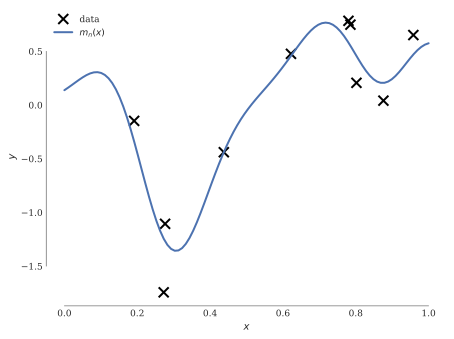

In [5]:
model.eval()
likelihood.eval()
# The test points on which we will make predictions
x_star = torch.linspace(0, 1, 100)[:, None]
# The predictive mean and variance for the test points
f_star = model(x_star)
# Now we need to pass through the likelihood - this is different from before
y_star = likelihood(f_star)
# Here is the mean
m_star = y_star.mean
fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Extracting the variance is a bit more involved.
Just a tiny bit though.
This is because ``v_star`` returned by ``gpm.predict`` is not exactly $\sigma_n^2(x)$.
It is actually $\sigma_n^2(x) + \sigma^2$ and not just $\sigma_n^2(x)$.
Here, see it:

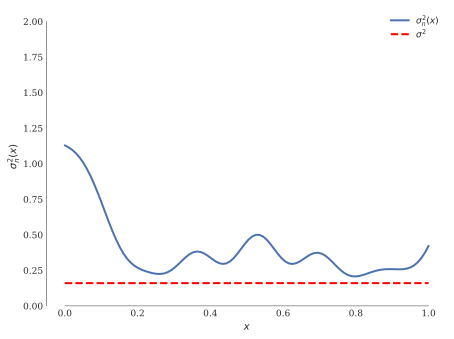

In [8]:
fig, ax = plt.subplots()
yv_star = y_star.variance
ax.plot(x_star, yv_star.detach(), lw=2, label=r'$\sigma_n^2(x)$')
ax.plot(
    x_star,
    model.likelihood.noise.detach() * np.ones(x_star.shape[0]),
    'r--',
    lw=2,
    label=r'$\sigma^2$'
)

ax.set_ylim(0, 2.1)
plt.legend(loc='best', frameon=False)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$\sigma_n^2(x)$')
sns.despine(trim=True);

Notice that the variance is small wherever we have an observation.
It is not, however, exactly, $\sigma^2$.
It will become exactly $\sigma^2$ in the limit of many observations.
Here $\sigma^2$ is the aleatory uncertainty. The remaining uncertainty is epistemic uncertainty.

Having the posterior mean and variance, we can derive 95\% predictive intervals for $f(x^*)$ and $y^*$.
For $f(x^*)$ these are:
$$
m_n(\mathbf{x}^*)) - 2\sigma_n(\mathbf{x}^*) \le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sigma_n(\mathbf{x}^*).
$$
Let's plot this:

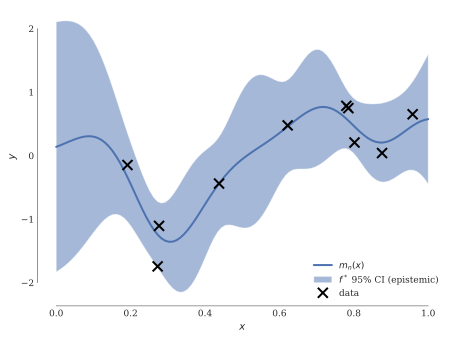

In [9]:
fig, ax = plt.subplots()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
v_star = f_star.variance
f_lower = m_star - 2.0 * torch.sqrt(v_star)
f_upper = m_star + 2.0 * torch.sqrt(v_star)
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
ax.fill_between(
    x_star.detach().flatten(),
    f_lower.detach().flatten(),
    f_upper.detach().flatten(),
    alpha=0.5,
    label='$f^*$ 95% CI (epistemic)'
)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Now, on the same plot, let's superimpose our predictive error bar about $y^*$.
This is:
$$
m_n(\mathbf{x}^*)) - 2\sqrt{\sigma_n^2(\mathbf{x}^*)+\sigma^2}\le f(\mathbf{x}^*) \le m_n(\mathbf{x}^*)) + 2\sqrt{\sigma_n(\mathbf{x}^*) + \sigma^2}.
$$
Let's use red color for this:

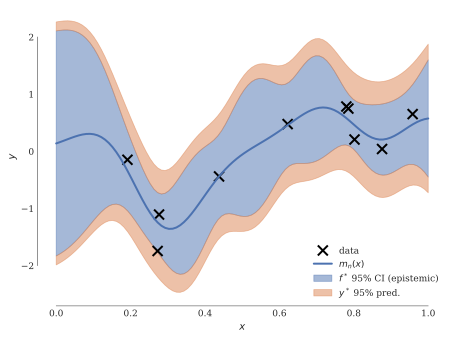

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
y_lower = m_star - 2.0 * torch.sqrt(yv_star)
y_upper = m_star + 2.0 * torch.sqrt(yv_star)
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.plot(x_star, m_star.detach(), lw=2, label='$m_n(x)$')
ax.fill_between(
    x_star.detach().flatten(),
    f_lower.detach().flatten(),
    f_upper.detach().flatten(),
    alpha=0.5,
    color=sns.color_palette()[0],
    label='$f^*$ 95% CI (epistemic)'
)
ax.fill_between(
    x_star.detach().flatten(),
    y_lower.detach().flatten(),
    f_lower.detach().flatten(),
    alpha=0.5,
    color=sns.color_palette()[1],
    label='$y^*$ 95% pred.'
)
ax.fill_between(
    x_star.detach().flatten(),
    f_upper.detach().flatten(),
    y_upper.detach().flatten(),
    color=sns.color_palette()[1],
    alpha=0.5,
    label=None
)
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

Let's also put the correct function there for comparison:

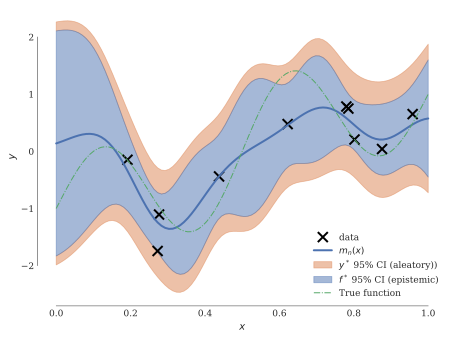

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='data')
ax.plot(
    x_star,
    m_star.detach(),
    lw=2,
    label='$m_n(x)$',
    color=sns.color_palette()[0]
)
y_lower = m_star - 2.0 * torch.sqrt(yv_star)
y_upper = m_star + 2.0 * torch.sqrt(yv_star)
ax.fill_between(
    x_star.detach().flatten(),
    y_lower.detach().flatten(),
    f_lower.detach().flatten(),
    color=sns.color_palette()[1],
    alpha=0.5,
    label='$y^*$ 95% CI (aleatory))'
)
ax.fill_between(
    x_star.detach().flatten(),
    f_upper.detach().flatten(),
    y_upper.detach().flatten(),
    color=sns.color_palette()[1],
    alpha=0.5,
    label=None
)
ax.fill_between(
    x_star.detach().flatten(),
    f_lower.detach().flatten(),
    f_upper.detach().flatten(),
    color=sns.color_palette()[0],
    alpha=0.5,
    label='$f^*$ 95% CI (epistemic)'
)
ax.plot(
    x_star,
    f_true(x_star),
    '-.',
    label='True function', 
    color=sns.color_palette()[2]
)
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

You see that the true function is almost entirely within the blue bounds.
It is ok that it is a bit off because these are 95% prediction intervals.
About 5% of the function can be off.

Let's now take some samples from the posterior:

In [12]:
f_post_samples = f_star.sample(sample_shape=torch.Size([10]))

/Users/ibilion/.pyenv/versions/3.12.5/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/ibilion/.pyenv/versions/3.12.5/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Let's plot them along with the data and the truth:

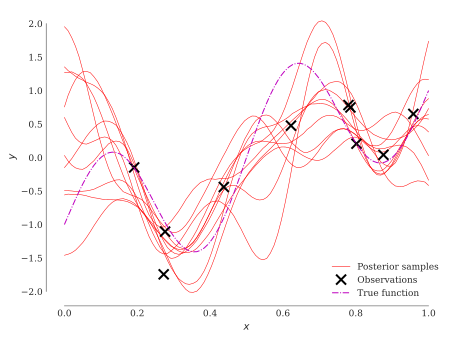

In [13]:
fig, ax = plt.subplots(dpi=100)
ax.plot(x_star, f_post_samples.detach().T, 'r', lw=0.5)
ax.plot([], [], 'r', lw=0.5, label="Posterior samples")
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x_star, f_true(x_star), 'm-.', label='True function')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

As before, let's organize the code into a function:

In [15]:
def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )
    
    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'kx',
            markersize=10,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='$m_n(x)$',
        color=sns.color_palette()[0]
    )
    
    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label=r'$f(\mathbf{x}^*)$ 95% pred.',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='$y^*$ 95% pred.'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )

    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )
        
    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star,
            f_post_samples.T.detach(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )
        
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True);

And here is how it works:

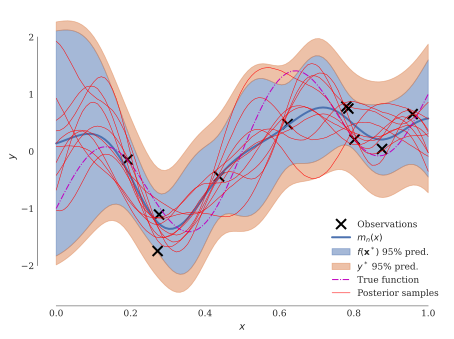

In [16]:
plot_1d_regression(x_star, model, f_true=f_true)

## Diagnostics: How do you know if the fit is good?

To objective test the resulting model, we need a *validation dataset* consisting of the inputs:

$$
\mathbf{x}^v_{1:n^v} = \left(\mathbf{x}^v_1,\dots,\mathbf{x}^v_{n^v}\right),
$$

and corresponding observed outputs:

$$
\mathbf{y}^v_{1:n^v} = \left(y^v_1,\dots,y^v_{n^v}\right).
$$

We will use this validation dataset to define some diagnostics.
Let's do it directly through the 1D example above.
First, we generate some validation data:

In [17]:
n_v = 100
X_v = np.random.rand(n_v)
Y_v = f_true(X_v) + sigma * np.random.randn(n_v)
X_v = torch.from_numpy(X_v).float()
Y_v = torch.from_numpy(Y_v).float()

### Point-predictions

Point-predictions only use $m_n\left(\mathbf{x}^v_i\right)$.
Of course, when there is a lot of noise, they are not very useful.
But let's look at what we get anyway.
(In the questions section, I will ask you to reduce the noise and repeat).

The simplest thing we can do is to compare $y^v_i$ to $m_n\left(\mathbf{x}^v_i\right)$.
We start with the *mean square error*:

$$
\operatorname{MSE} := \frac{1}{n^v}\sum_{i=1}^{n^v}\left[y^v_i-m_n\left(\mathbf{x}^v_i\right)\right]^2.
$$

In [18]:
f_v = model(X_v)
y_v = model.likelihood(f_v)
m_v = y_v.mean
v_v = y_v.variance

mse = torch.mean((Y_v - m_v) ** 2)
print(f'MSE = {mse:1.2f}')

MSE = 0.33


This could be more intuitive, though.
A somewhat intuitive measure is [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), also known as $R^2$, *R squared*.
It is defined as:

$$
R^2 = 1 - \frac{\sum_{i=1}^{n^v}\left[y_i^v - m_n(\mathbf{x}_i^v)\right]^2}{\sum_{i=1}^{n^v}\left[y_i^v-\bar{y}^v\right]^2},
$$

where $\bar{y}^v$ is the mean of the observed data:

$$
\bar{y}^v = \frac{1}{n^v}\sum_{i=1}^{n^v}y_i^v.
$$

The interpretation of $R^2$, and take this with a grain of salt, is that it gives the percentage of variance of the data explained by the model.
A score of $R^2=1$, is a perfect fit.
In our data, we get:

In [19]:
R2 = 1.0 - torch.sum((Y_v - m_v) ** 2) / torch.sum((Y_v - torch.mean(Y_v)) ** 2)
print(f'R2 = {R2:1.2f}')

R2 = 0.53


Finally, on point-predictions, we can simply plot the predictions vs the observations:

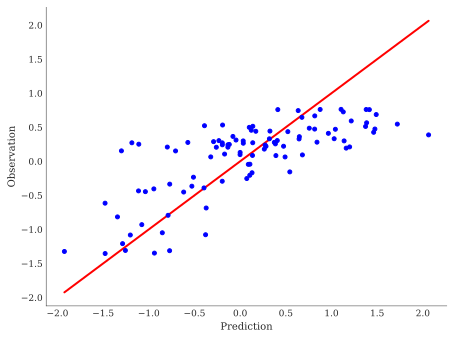

In [20]:
fig, ax = plt.subplots()
y_range = np.linspace(Y_v.min(), Y_v.max(), 50)
ax.plot(y_range, y_range, 'r', lw=2)
ax.plot(Y_v.detach(), m_v.detach(), 'bo')
ax.set_xlabel('Prediction')
ax.set_ylabel('Observation');

### Statistical diagnostics

Statistical diagnostics compare the predictive distribution to the distribution of the validation dataset.
The way to start are the standardized errors defined by:

$$
e_i = \frac{y_i^v - m_n\left(\mathbf{x}^v_i\right)}{\sigma_n\left(\mathbf{x}^v_i\right)}.
$$

If our model is correct, the standardized errors must be distributed as a standard normal $N(0,1)$ (why?).
There are various plots that you can do to test that.
First, the histogram of the standardized errors:

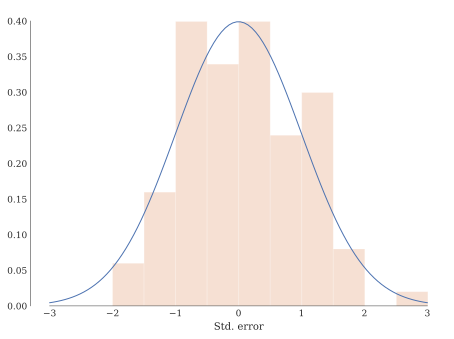

In [21]:
import scipy.stats as st

s_v = torch.sqrt(v_v)
e = (Y_v - m_v) / s_v
fig, ax = plt.subplots()
zs = np.linspace(-3.0, 3.0, 100)
ax.plot(zs, st.norm.pdf(zs))
ax.hist(e.detach(), density=True, alpha=0.25)
ax.set_xlabel('Std. error')
sns.despine(trim=True);

Close, but not perfect.
Another common plot is this:

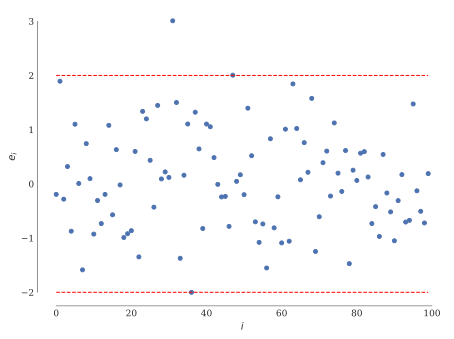

In [22]:
fig, ax = plt.subplots()
ax.plot(e.detach(), 'o')
ax.plot(np.arange(e.shape[0]), 2.0 * np.ones(e.shape[0]), 'r--')
ax.plot(np.arange(e.shape[0]), -2.0 * np.ones(e.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$e_i$')
sns.despine(trim=True);

Where the red lines indicate the 95% quantiles of the standard normal.
This means that if 5\% % of the errors are inside, we are good to go.

Yet another plot yielding the same information is the q-q plot comparing the empirical quantiles of the standardized errors to what they are supposed to be, i.e., to the quantiles of $N(0,1)$:

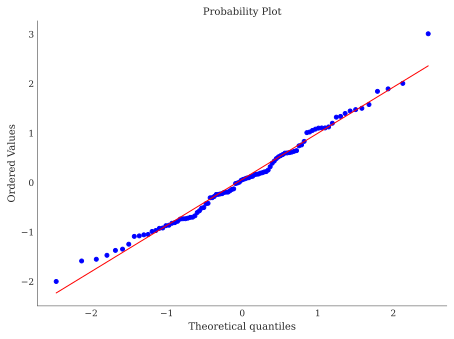

In [23]:
fig, ax = plt.subplots(dpi=100)
st.probplot(e.detach().flatten(), dist=st.norm, plot=ax);

### Note on Gaussian process diagnostics

For a more detailed description of GP regression diagnostics, please see {cite:p}`3230516c-5e5c-34ef-aef1-442899abfb0a`.

### Questions

+ Experiment with different lengthscales for the kernel.
What happens to the posterior mean and the 95% predictive error bar as the length scale increases (decreases)?

+ Experiment with difference likelihood variances. What happens for huge variances? What happens for tiny variances?

+ Experiment with different kernel variances.

+ Try some other kernels. 

+ Experiment with large numbers of training points $n$. Are the models becoming better according to the metrics we defined above?